In [30]:
import torch
import numpy as np  
import torch.nn.functional as F
print("Using torch", torch.__version__)

Using torch 2.5.0.dev20240702


In [31]:
torch.manual_seed(42)

In [32]:
np_arr = np.array([[1, 2, 3], [4, 5, 6]])
torch_arr = torch.from_numpy(np_arr)
print(torch_arr)

tensor([[1, 2, 3],
        [4, 5, 6]])


In [33]:
np_arr = torch_arr.numpy()
print(np_arr)
print(type(np_arr))

[[1 2 3]
 [4 5 6]]
<class 'numpy.ndarray'>


In [34]:
x1 = torch.rand(2, 3)
x2 = torch.rand(2, 3)
y = x1 + x2

print("X1", x1)
print("X2", x2)
print("Y", y)

X1 tensor([[0.8823, 0.9150, 0.3829],
        [0.9593, 0.3904, 0.6009]])
X2 tensor([[0.2566, 0.7936, 0.9408],
        [0.1332, 0.9346, 0.5936]])
Y tensor([[1.1388, 1.7086, 1.3236],
        [1.0925, 1.3250, 1.1945]])


inplace

In [35]:
x2.add_(x1)

tensor([[1.1388, 1.7086, 1.3236],
        [1.0925, 1.3250, 1.1945]])

In [36]:
x = torch.arange(6)
x = x.view(2,3)
print(x)

tensor([[0, 1, 2],
        [3, 4, 5]])


In [37]:
x = x.permute(1,0)
print(x)

tensor([[0, 3],
        [1, 4],
        [2, 5]])


In [38]:
from torchvision.datasets import  FashionMNIST
from torchvision import transforms
import torch.utils.data as data


In [39]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2861,), (0.3530,))
])

trainset = FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])
testset = FashionMNIST(root='./data', train=False,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=64,
                                        shuffle=False, num_workers=2)


testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=64, shuffle=False,
                                         num_workers=2)

In [40]:
imgs, _ = next(iter(trainloader))
print(f"Mean: {imgs.mean().item():5.3f}")
print(f"Standard deviation: {imgs.std().item():5.3f}")
print(f"Maximum: {imgs.max().item():5.3f}")
print(f"Minimum: {imgs.min().item():5.3f}")

Mean: -0.045
Standard deviation: 0.956
Maximum: 2.022
Minimum: -0.810


In [41]:
import pytorch_lightning as pl
pl.seed_everything(42)

Seed set to 42


42

In [42]:
## Standard libraries
import os
import numpy as np
import random
from PIL import Image
from types import SimpleNamespace

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

/var/folders/f2/gq8xgm9x491cqwtct_tgpy0h0000gn/T/ipykernel_29267/4060246365.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [43]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial5"

# Function for setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [44]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial5/"
# Files to download
pretrained_files = ["GoogleNet.ckpt", "ResNet.ckpt", "ResNetPreAct.ckpt", "DenseNet.ckpt",
                    "tensorboards/GoogleNet/events.out.tfevents.googlenet",
                    "tensorboards/ResNet/events.out.tfevents.resnet",
                    "tensorboards/ResNetPreAct/events.out.tfevents.resnetpreact",
                    "tensorboards/DenseNet/events.out.tfevents.densenet"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive fo")

In [45]:
train_dataset = CIFAR10(root=DATASET_PATH, train=True, download=True)
DATA_MEANS = (train_dataset.data / 255.0).mean(axis=(0,1,2))
DATA_STD = (train_dataset.data / 255.0).std(axis=(0,1,2))
print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)

Files already downloaded and verified
Data mean [0.49139968 0.48215841 0.44653091]
Data std [0.24703223 0.24348513 0.26158784]


In [51]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32), scale=(0.8,1.0), ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS,DATA_STD)])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEANS,DATA_STD)])


# This is a smart trick because we dont want the validation set to use the augmeneted data we used for the training set

train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)

set_seed(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
set_seed(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

BATCH_SIZE = 128

train_loader = data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last= True, pin_memory= True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [54]:
#verifying that normalization works
imgs, _ = next(iter(train_loader))
print("Batch Mean", imgs.mean(dim=[0,2,3]))
print("Batch Std", imgs.std(dim=[0,2,3]))

Batch Mean tensor([ 0.0030, -0.0410, -0.0230])
Batch Std tensor([1.0009, 1.0105, 1.0183])


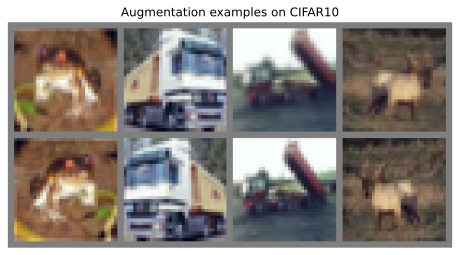

In [55]:
NUM_IMAGES = 4
images = [train_dataset[idx][0] for idx in range(NUM_IMAGES)]
orig_images = [Image.fromarray(train_dataset.data[idx]) for idx in range(NUM_IMAGES)]
orig_images = [test_transform(img) for img in orig_images]
img_grid = torchvision.utils.make_grid(torch.stack(images + orig_images, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Augmentation examples on CIFAR10")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()



In [56]:
import pytorch_lightning as pl
pl.seed_everything(42)

Seed set to 42


42

In [57]:
class  CIFARModule(pl.LightningModule):
    def __init__(self, model_name, model_hparams, otpimizer_name, optimizer_hparams):
        super().__init__()
        
        self.save_hyperparameters()
        self.model = create_model(model_name, model_hparams)
        self.loss_module = nn.CrossEntropyLoss()
        self.example_input_array = torch.zeroes((1,3,32,32), dtype=torch.float32)
        
    def forward(self, imgs):
        return self.model(imgs)
    
    def configure_optimizers(self):
        
        if self.haparams.optimizer_name == 'Adam':
            optimizer = optim.Adam(self.parameters(), **self.hparams.optimizer_hparams)
        elif self.haparams.optimizer_name == 'SGD':
            optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            raise ValueError('Optimizer not recognized')
        
        scheduler = optim.lr_scheduler.MultistepLP( optimizer, milestones = [100,150], gamma = 0.1)
        
        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        
        self.log('train_acc', acc, on_step = False, on_epoch = True, prog_bar = True)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self,batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (preds == labels).float().mean()
        self.log('val_acc', acc)
        
    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (preds == labels).float().mean()
        self.log('test_acc', acc)
        

Another important part of PyTorch Lightning is the concept of callbacks. Callbacks are self-contained functions that contain the non-essential logic of your Lightning Module. They are usually called after finishing a training epoch, but can also influence other parts of your training loop. For instance, we will use the following two pre-defined callbacks: LearningRateMonitor and ModelCheckpoint. The learning rate monitor adds the current learning rate to our TensorBoard, which helps to verify that our learning rate scheduler works correctly. The model checkpoint callback allows you to customize the saving routine of your checkpoints. For instance, how many checkpoints to keep, when to save, which metric to look out for, etc. We import them below:

In [58]:
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor


In [59]:
model_dict = {}

def create_model(model_name, model_hparams):
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else:
        assert False, f"Unknown model name \"{model_name}\". Available models are: {str(model_dict.keys())}"

In [60]:
act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "leakyrelu": nn.LeakyReLU,
    "gelu": nn.GELU
}